# Creative Extension Analysis

---


In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Hiding the warnings
import warnings; warnings.simplefilter('ignore')

# Set random seed for consistency 
import random
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
seed = 42
random.seed(seed)
np.random.seed(seed)

# Importing RE (regular expression) module for preprocessing step
import re

# Natural Language Toolkits
import nltk

# Vader 
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Bert sa-pipeline
from transformers import pipeline

#topic
from empath import Empath
import os.path

from scipy import stats
from datetime import datetime, date, time

## Step 1. Data Collection
___

How we collected the data

**DID YOU COLLECT ONLY DATA COMING FROM REAL USERS FROM THE DATASET IN THE ORIGINAL PAPER? IMPORTANT IF WE NEED TO REMOVE THEM**

## Step 2. Data Loading & Data Organization
___

In [2]:
# Loading the dataset

tweets = pd.read_csv('./Data/tweets',low_memory=False)
tweets.head()

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified
0,NaN,Sun Feb 14 23:29:33 +0000 2010,NaN,NaN,NaN,0,9116606357,NaN,NaN,NaN,...,29,17,0,"Sofia, Bulgaria",Ina Gerdjikova,InaGerdjikova,6,NaN,http://kutiazamisli.blogspot.com/,False
1,NaN,Fri Sep 24 20:40:25 +0000 2010,NaN,NaN,NaN,0,25437022568,NaN,NaN,NaN,...,12,9,0,NaN,Ana Paula Ribeiro,anadadal,7,NaN,NaN,False
2,NaN,Tue Jun 14 07:54:35 +0000 2011,NaN,NaN,http://kutiazamisli.blogspot.com/2011/06/blog-...,0,80543642816757761,NaN,NaN,NaN,...,29,17,0,"Sofia, Bulgaria",Ina Gerdjikova,InaGerdjikova,6,NaN,http://kutiazamisli.blogspot.com/,False
3,NaN,Tue Aug 12 17:51:37 +0000 2014,NaN,NaN,http://twitcam.livestream.com/g7hpe,0,499251874256920577,NaN,NaN,NaN,...,12,9,0,NaN,Ana Paula Ribeiro,anadadal,7,NaN,NaN,False
4,NaN,Fri Oct 25 11:38:21 +0000 2013,SmurfsVillage,NaN,http://bit.ly/Smurf47,0,393703073228808192,NaN,NaN,NaN,...,6,17,0,Land of the happily single,sheena c wallace,sheasofly,268,NaN,NaN,False


In [3]:
#reading in the dataframe
ego_alt_prof = pd.read_csv('./Data/EgoAlterProfiles.txt', delimiter = "\t").set_index('ID')

#visualize that the dataframe was imported correctly
ego_alt_prof.head(3)

,IsEgo,followers_count,friends_count,statuses_count,utc_offset,lang,created_at,protected
ID,,,,,,,,
1,True,30.0,28,9.0,NaN,en,Wed Oct 26 03:30:32 +0000 2011,False
2,True,2.0,8,7.0,-14400.0,en,Mon Jul 27 20:46:32 +0000 2009,False
3,True,1.0,0,0.0,NaN,fr,Mon Apr 23 20:57:26 +0000 2012,False


In [4]:
#reading in the dataframe using the encoding found in the previous cell
ego_timelines = pd.read_csv('./Data/EgoTimelines.txt', encoding = "ISO-8859-1",delimiter = "\t")

#visualize that the dataframe was imported correctly
ego_timelines.head(3)

,replyto_userid,retweeted_userid,id,tweetid,created_at,hashtags,urls,mentions_ids,retweet_count,egoID,retweetedUserID,replytoUserID,metionID
0,NaN,NaN,398477318,249552537051598848,Sat Sep 22 16:55:35 +0000 2012,NaN,NaN,2810549959,0,1,NaN,NaN,NaN
1,NaN,NaN,398477318,249537963145433088,Sat Sep 22 15:57:41 +0000 2012,NaN,NaN,2810549959,0,1,NaN,NaN,NaN
2,NaN,NaN,398477318,129377372209299456,Thu Oct 27 02:02:23 +0000 2011,NaN,NaN,NaN,0,1,NaN,NaN,NaN


In [5]:
#merging dataframes to add utc_offset column
ego_merge = pd.merge(ego_timelines,ego_alt_prof['utc_offset'], how='inner', left_on='egoID',\
                     right_on=ego_alt_prof.index)

#only keep columns useful to the replciation
ego_merge = ego_merge[['tweetid', 'utc_offset']]

#visualize resulting dataframe
ego_merge.head(5)

,tweetid,utc_offset
0,249552537051598848,NaN
1,249537963145433088,NaN
2,129377372209299456,NaN
3,302401054690140160,NaN
4,249538739611787264,NaN



## Step 3. Data Preprocessing


---

First, we are going to select only english tweets and delete repetitive tweets.

Then, we are going to apply some essential steps useful in any natural language processing (NLP) task.

- **Tokenizing**, convert character string into sequence of tokens, that is words separated by white spaces. Tokenicazion in text such as tweets is or crucial importance. Indeed, we can find punctuation marks such as *!?* or *:-)* that we will like tokeep together because they have a intrinsic meaning. We do not want to separe them. Tokenization in twitter is quite straithforward, and on Python it can be implemented with the nltk library.

- The dedicated toolkits will be used as a part of the preprocessing process [TweetNLP](https://www.cs.cmu.edu/~ark/TweetNLP/#pos_down). In social media it is common to find mispelled words, the repetition of letters or syllabes ("lololol", "ahahahah", "yeaahhhh") and abbreviation and slang ("idk" for I don't know, or "imo" for in my opinion). To deal with this variabilities we need packages created only for social media.


### Step 3.1: Tweets Cleaning Step
Filtering out the inadequate tweets for the analysis.
___

In [6]:
# Exploring the dataset

print(f"In total there are {len(tweets)} tweets.")

In total there are 1609389 tweets.


For this analysis we are only concerned with english tweets, so we need to filter the data using the language information

In [7]:
# Selecting only english tweets

en_tweets = tweets.loc[tweets['lang']=='en']
print(f"In total there are {len(en_tweets)} english tweets.")

In total there are 1093122 english tweets.


We also want to drop duplicate tweets. The reason for this is because if a tweet is repeated many times, then it is most likely due to a bot account. With this analysis we are concern with the sentiment of real users, so data from bot accounts could disrupt the results

In [8]:
# Demonstrating examples of duplicate tweets
en_tweets.value_counts(subset = 'text', sort = True)[0:5]


text
IF U HAVE A FACEBOOK ACCOUNT,PLZ TELL ME UR ACCOUNTNAME&lt;333 U U TELL ME IT WHEN I TELL U MINE:)    2738
Here is a neat little package to create banners  http://perfecttrafficstorm.com/links/19768            171
Check this Out  http://perfecttrafficstorm.com/links/19778                                             170
Grab this package of articles    http://perfecttrafficstorm.com/links/19769                            169
Check out the PLR CHEATER http://perfecttrafficstorm.com/links/19773                                   169
dtype: int64

In [9]:
# Dropping all duplicates tweets
en_tweets.drop_duplicates(subset=['text'], keep = False, inplace = True)
print(f"After dropping the duplicates, there are {len(en_tweets)} english tweets.")


After dropping the duplicates, there are 1054619 english tweets.


In [10]:
# Checking how many users we have 
usernames = en_tweets.value_counts(subset = 'user_name', sort = True)
print(f"There are a total of {len(usernames)} users which posted {len(en_tweets)} english tweets.")
usernames.head(5)


There are a total of 6167 users which posted 1054619 english tweets.


user_name
michelle              3906
Austin Health Jobs    3197
Mark Whittington      3189
Games For Pro         3188
BELIVE ADULT          3162
dtype: int64

In [11]:
# Giving a look to some tweet texts

print(en_tweets.text.iloc[0])
print(en_tweets.text.iloc[1])


Will try to live for a week offline... wish me luck! :D
Boa tarde..
 (@shekinahbiscuit live on http://t.co/nU1N0NJJIJ)


### Step 3.2:  Noise Removal Step
We will remove special characters from the tweets that could affect the VADER analyser but being careful to not remove any important feature which can help in understanding better the sentiment of the tweets. 

For example, we will not perform  **letter casing**, that is converting all letters in lower case. Indeed, in text such as tweets often the upper case is used to emphatise a concept: great and GREAT have a different sentiment intensity. In addition to that, as we have seen in class, casefolding could create confusion between words such as apple and Apple.  


On the contrary, we will remove unwanted characters such as URLs (“http://url”), user mentions @ ("@username") and hashtags symbols # (we will keep however the word of the hashtag because it might contain useful information). To do that, we follow the steps of [Shihab Elbagir and Jing Yang](http://www.iaeng.org/publication/IMECS2019/IMECS2019_pp12-16.pdf) and 
[Toni Pano and Rasha Kashef](https://www.mdpi.com/2504-2289/4/4/33).

We will also keep the "..." because they can give some insights of the tweet.

**In the paper they also remove “RT @username.”. I would do the same bacause we are extrapolating the RT from the relative columns but i want to ask you before. ALso they removed numbers, but i don't think it is a big deal having them**
___

In [12]:
## Noise Removal 

# Using the RE (regular expression) module and the replace function to remove the unwanted characters.

# Parameters for re.sub function:
# 'r' added to not handle backslashes in any special way in the following string
# https? will match either ‘http’ or ‘https’
# https?:\/\/ will match any "http://" and "https://" in the following string
# \S Returns a match when the string does not contain a white space character inside. 
    # Indeed, we want to keep the test that follows the URL.
# * Needed to select the whole text when no white spaces in the middle



clean_tweets = [] 
for i in range(len(en_tweets)):
    
    # Selecting one tweet
    text_i = en_tweets.text.iloc[i]
        
    # Replacing the URL with a white space
    text_i = re.sub(r'https?:\/\/\S*', '', text_i, flags = re.MULTILINE)
    
    # Replacing the www. with a white space
    text_i = re.sub(r'www.\S*', '', text_i, flags = re.MULTILINE)
    
    # Replacing the RT retweet RT @username with a white space
    text_i = re.sub(r'RT @\S*', '', text_i, flags = re.MULTILINE)
    
    # Replacing the user mention @username with a white space
    # This needs to go after the "RT @username" removal
    text_i = re.sub(r'@\S*', '', text_i, flags = re.MULTILINE)
    
    # Replacing the hashtag symbol # with a white space
    text_i = text_i.replace("#", "")
    
    # Replacing the \n (new line) with a white space
    text_i = text_i.replace("\n", "")
    
    # append the cleaned tweet to the list previously initialized
    clean_tweets.append(text_i) 

    
# Add the new column to the original df
en_tweets['clean_tweets'] = clean_tweets

In [13]:
print(clean_tweets[55656])
print(en_tweets.text[55656],'\n')

print(clean_tweets[1054615])
print(en_tweets.text[1054615])

 Sometimes you gotta accept the fact that certain things will never go back to how they use to be.
@nmabadeje abi, sha nw even jst boxers no de allowed 

 Hi lovely 💕  You are my world, my life, my love.  I'm so proud of you,You follow me please? don't ign…
RT @ofcourseimjk: it's the weekend http://t.co/GciT2IGvSW


In [14]:
# compare before and after preprocessing with a tweet that contains all of them.
print(en_tweets.text.iloc[8])
print(clean_tweets[8],'\n')

print(clean_tweets[1])
en_tweets.text.iloc[1] # to see the \n, if we print do not see it

Have you been to the mountain? Reach new heights on the #SmurfVillage mountain! http://t.co/d9BVrqiU82 @BeelineGames
Have you been to the mountain? Reach new heights on the SmurfVillage mountain!   

Boa tarde.. ( live on 


'Boa tarde..\n (@shekinahbiscuit live on http://t.co/nU1N0NJJIJ)'

### Step 3.3:  Tokenization and stop words removal
___

The removal of stop words requires before the tokenzation. We want to remove any stop word that the VADER's dictionary does not use ([Toni Pano and Rasha Kashef](https://www.mdpi.com/2504-2289/4/4/33)). Indeed, we need to be careful when deleting stop word from a text that will be analysed by pre-computed sentiment analysis libraries. It can be detrimental for the sentiment scores.

In [15]:
import typing # maybe find a better way for it

In [16]:
# Classical english stop words

from nltk.corpus import stopwords
stopcorpus: typing.List = stopwords.words('english')
print(stopcorpus)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

As you can see, between these stop words there are some which are actually useful for our goal. For example "very" and "most" can increase the tweet sentiment intensity. Therefore, we need to define a custom list of stopwords. 

In [17]:
# Selecting the customed list of stopwords

with open("helpers/stopwords.txt") as f:
    customed_stop_words = list(map(lambda x: x[:-1], f.readlines()))

In [18]:
# function to remove the stop words

def remove_words(text_data: str, words_to_remove: typing.List):
    return [item for item in text_data if item not in words_to_remove]

In [19]:
# Applying filter for stop words and visualizing them 

tweets_no_sw = en_tweets.clean_tweets.astype(str).apply(lambda x: remove_words(x.split(),customed_stop_words))
tweets_no_sw

0          [Will, try, live, week, offline..., wish, luck...
3                                    [Boa, tarde.., (, live]
8                [Phew..., Valentine's, day, finally, hours]
9                                                  [(, live]
11                                          [simmm, (, live]
                                 ...                        
1609378                            [carry, fantasy, victory]
1609385    [Hi, lovely, 💕, You, world,, life,, love., I'm...
1609386    ["Many, things, Satanism, offensive.", -, Thin...
1609387                    [Smite, ArtemisStalkerSkin, Free]
1609388    [New, Ministry, of, Magic, song!, :D, &lt;3, I...
Name: clean_tweets, Length: 1054619, dtype: object

In [20]:
# Removing the stop words already does toketization... but the !!! stays with it,
# it shouldnt be this way i guess

print(en_tweets.clean_tweets.iloc[14])
print(tweets_no_sw.iloc[14])

Seafood salad and fried chicken and sweet tea I'm hype. Now to cook it!!!
['Seafood', 'salad', 'fried', 'chicken', 'sweet', 'tea', "I'm", 'hype.', 'Now', 'cook', 'it!!!']


Now we have a series of list. To use the Sentiment Analyzer VADER we need to convert it to a string.

In [21]:
# From list to string

def listToString(tweet_list):  
    # initialize an empty string 
    str1 = " " 
    # return string   
    return (str1.join(tweet_list)) 

tweets_no_sw_string = []
for i in tweets_no_sw:
    no_sw = listToString(i)
    tweets_no_sw_string.append(no_sw)

In [22]:
# Add the new feature to the original df

en_tweets['no_sw_tweets'] = tweets_no_sw_string
en_tweets.head()

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified,clean_tweets,no_sw_tweets
0,NaN,Sun Feb 14 23:29:33 +0000 2010,NaN,NaN,NaN,0,9116606357,NaN,NaN,NaN,...,0,"Sofia, Bulgaria",Ina Gerdjikova,InaGerdjikova,6,NaN,http://kutiazamisli.blogspot.com/,False,Will try to live for a week offline... wish me...,Will try live week offline... wish luck! :D
3,NaN,Tue Aug 12 17:51:37 +0000 2014,NaN,NaN,http://twitcam.livestream.com/g7hpe,0,499251874256920577,NaN,NaN,NaN,...,0,NaN,Ana Paula Ribeiro,anadadal,7,NaN,NaN,False,Boa tarde.. ( live on,Boa tarde.. ( live
8,NaN,Sun Feb 14 18:46:26 +0000 2010,NaN,NaN,NaN,0,9107804301,NaN,NaN,NaN,...,0,"Sofia, Bulgaria",Ina Gerdjikova,InaGerdjikova,6,NaN,http://kutiazamisli.blogspot.com/,False,Phew... Valentine's day will be finally over i...,Phew... Valentine's day finally hours
9,NaN,Fri Sep 28 19:07:04 +0000 2012,NaN,NaN,http://twitcam.livestream.com/c7fe0,0,251759950655791105,NaN,NaN,NaN,...,0,NaN,Ana Paula Ribeiro,anadadal,7,NaN,NaN,False,up ( live on,( live
11,NaN,Fri Sep 28 19:05:53 +0000 2012,NaN,NaN,http://twitcam.livestream.com/c7fe0,0,251759653464199168,NaN,NaN,NaN,...,0,NaN,Ana Paula Ribeiro,anadadal,7,NaN,NaN,False,simmm ( live on,simmm ( live


In [23]:
# comparison between with and without stop words

example1 = en_tweets.clean_tweets.iloc[17]
example2 = en_tweets.no_sw_tweets.iloc[17]

analyzer = SentimentIntensityAnalyzer()
vs = analyzer.polarity_scores(example1)

print(example1, '\n')
print('Negative sentiment:',vs['neg'])
print('Neutral sentiment:',vs['neu'])
print('Positive sentiment:',vs['pos'])
print('Compound sentiment:',vs['compound'],'\n')

vs = analyzer.polarity_scores(example2)

print(example2, '\n')
print('Negative sentiment:',vs['neg'])
print('Neutral sentiment:',vs['neu'])
print('Positive sentiment:',vs['pos'])
print('Compound sentiment:',vs['compound'])

Smurfette spaces out in the SmurfsVillage. She makes Smurfs and Swoofs swoon and awards XP!  

Negative sentiment: 0.0
Neutral sentiment: 0.81
Positive sentiment: 0.19
Compound sentiment: 0.5093 

Smurfette spaces SmurfsVillage. She makes Smurfs Swoofs swoon awards XP! 

Negative sentiment: 0.0
Neutral sentiment: 0.732
Positive sentiment: 0.268
Compound sentiment: 0.5093


In [ ]:
# Here I am trying to do the tokenization we saw in class, but it divides the three !!!, this is not rigth

import spacy, nltk, sklearn
nlp = spacy.load('en')


example = en_tweets.clean_tweets.iloc[14]
#example = en_tweets.text[55656]
doc = nlp(example)
tokens = [token.text for token in doc]

print(example,'\n')
print(tokens)

#example = en_tweets.clean_tweets[6] and [11]
#Here ?! and !!! separated with token, not good

### Step 3.4:  Processing the data for analysis of day/hour 
___

Part of our analysis, is to understand if the moment of the day of the week can somehow influences the tweet sentiment and its retweetability. To do that, we need before to include in out dataframe the information regarding the utc_offset data and convert the time of posting in local time.

In [ ]:
#merging dataframes to add utc_offset column
en_tweets = pd.merge(en_tweets,ego_merge, how = 'inner', left_on = 'id', right_on = 'tweetid')

en_tweets.columns

In [ ]:
en_tweets['date'] = en_tweets.created_at.apply(lambda d: datetime.strptime(d, '%a %b %d %H:%M:%S +0000 %Y'))

In [ ]:
def get_seconds(date):
    seconds = (date.hour*3600) + (date.minute*60) + date.second
    return seconds

def day_change(time):
    return 1 if time > 86400 else -1 if time < 0 else 0

def fix_time(time):
    return time - 86400 if time > 86400 else time + 86400 if time < 0 else time


In [ ]:
en_tweets['day_seconds'] = en_tweets.date.apply(lambda x: get_seconds(x)) + en_tweets['utc_offset']

In [ ]:
en_tweets['day_number'] = en_tweets.date.apply(lambda x: x.weekday())

In [ ]:
en_tweets['norm_day'] = en_tweets.day_seconds.apply(lambda x: day_change(x)) + en_tweets.day_number
days=["Mon","Tue","Wed","Thur","Fri","Sat","Sun"]
en_tweets['day'] =  en_tweets.norm_day.apply(lambda x: days[x%7])

In [ ]:
en_tweets['day_seconds'] = (en_tweets.day_seconds.apply(lambda x: fix_time(x)))
en_tweets['hour'] = en_tweets['day_seconds']//3600
en_tweets.hour.replace(24,0, inplace=True)

en_tweets.columns

Let's only keep columns we are interested in

In [ ]:
# I prefer to keep all the columns

#en_tweets =  en_tweets[['hashtags', 'media', 'urls', 'id', 'place', 'retweet_count', 'text', 'user_followers_count', 'user_friends_count',
#                       'user_location', 'user_name', 'user_screen_name.1', 'user_statuses_count', 'user_verified', 'clean_tweets', 
#                       'tweetid', 'utc_offset', 'date', 'day', 'hour']]
#en_tweets.head(3)

## Step 4. Rule-based sentiment analysis - VADER

---

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon- and rule-based sentiment analyser that can deal with words, abbreviations, slang, emoticons, and emojis commonly found in social media ([Toni Pano and Rasha Kashef](https://www.mdpi.com/2504-2289/4/4/33)). Every text produces four sentiments scores: positive, neutral, negative and the compound polarity. The first three features describe how much the particular tweet is positive, neutral or neutral in a range between 0 and 1. On the contrary, the compound polarity score can be seen as an aggregate measure of the sentiment of the tweets, indeed it goes from - 1 (negative) and 1 (positive). In our case, we will use this polarity score to determine the sentiment of the tweets applying a threshold. From the literature, we found several threshoulds and here we try with **blablabla**

### Step 4.1: Results with the cleaned tweets and threshold equals to 0.05
___

In [25]:
#Initializing the Rule-based sentiment analyzer 
analyzer1 = SentimentIntensityAnalyzer()

In [26]:
en_tweets['sent_score'] = [analyzer1.polarity_scores(x)['compound'] for x in en_tweets['clean_tweets']]

In [27]:
def sentiment_05(scores):
    sents = []
    for score in scores:
        if score >= 0.05:
            sent = 'pos'
        elif score <= -0.05:
            sent = 'neg'
        elif abs(score) <0.05:
            sent = 'neu'
        sents.append(sent)
    return sents

In [28]:
en_tweets['sentiment'] = sentiment_05(en_tweets.sent_score)

In [29]:
grouped_sents = en_tweets.groupby(by='sentiment')

In [30]:
print('Number of positive sentences:',sum(np.array(en_tweets['sent_score'])>=0.05))
print('Number of negative sentences:',sum(np.array(en_tweets['sent_score'])<=-0.05))
print('Number of neutral sentences:',sum(np.abs(np.array(en_tweets['sent_score']))<0.05))

Number of positive sentences: 484802
Number of negative sentences: 209729
Number of neutral sentences: 360088


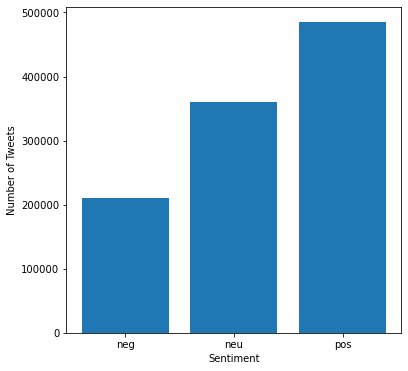

In [31]:
plt.figure(figsize=(6,6))
plt.bar(grouped_sents.size().index, grouped_sents.size().values, width=0.8)
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

### Step 4.2: Results with the cleaned tweets and threshold equals to 0.001
___

In [ ]:
# Threshold as in the other paper 

def sentiment_001(scores):
    sents = []
    for score in scores:
        if score >= 0.001:
            sent = 'pos'
        elif score <= -0.001:
            sent = 'neg'
        elif abs(score) <0.001:
            sent = 'neu'
        sents.append(sent)
    return sents

en_tweets['sentiment'] = sentiment_001(en_tweets.sent_score)
grouped_sents2 = en_tweets.groupby(by='sentiment')

plt.figure(figsize=(6,6))
plt.bar(grouped_sents2.size().index, grouped_sents2.size().values, width=0.8)
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

### Step 4.3 Results with the cleaned tweets without stop words
___

In [ ]:
analyzer_no_sw = SentimentIntensityAnalyzer()
en_tweets['sent_score_no_sw'] = [analyzer_no_sw.polarity_scores(x)['compound'] for x in en_tweets['no_sw_tweets']]

en_tweets['sentiment_no_sw'] = sentiment_05(en_tweets.sent_score_no_sw)
grouped_sents = en_tweets.groupby(by='sentiment_no_sw')

plt.figure(figsize=(6,6))
plt.bar(grouped_sents.size().index, grouped_sents.size().values, width=0.8)
plt.xlabel('Sentiment_no_sw')
plt.ylabel('Number of Tweets')
plt.show()

### Step 4.4 Results with the raw tweets
___

In [ ]:
analyzer_raw = SentimentIntensityAnalyzer()
en_tweets['sent_score_raw'] = [analyzer_raw.polarity_scores(x)['compound'] for x in en_tweets['text']]

en_tweets['sentiment_raw'] = sentiment_05(en_tweets.sent_score_no_sw)
grouped_sents = en_tweets.groupby(by='sentiment_raw')

plt.figure(figsize=(6,6))
plt.bar(grouped_sents.size().index, grouped_sents.size().values, width=0.8)
plt.xlabel('Sentiment_raw')
plt.ylabel('Number of Tweets')
plt.show()

It seems a bit weird, but neither changing the threshould or including/removing the stop words or using the raw data  make the analysis different. 
**VERY WEIRD NEED TO DOUBLE CHECK**

## Step 5. Bert SA-pipeline
___

In [ ]:
sa_pipeline = pipeline('sentiment-analysis')

In [ ]:
for i in range(10):
    text = en_tweets['text'].iloc[i]
    print(text)
    prediction = sa_pipeline(text)
    print(prediction)
    print()

## Step 6: Sentiment VS time
___

For the following analysis we will focus only on subjective (positive and negative tweets).

In [ ]:
# removing tweets without utc_offset information
en_tweets_time = en_tweets.dropna(subset=['utc_offset'])

pos_sents_time = en_tweets_time.loc[en_tweets_time['sentiment'] == 'pos']
neg_sents_time = en_tweets_time.loc[en_tweets_time['sentiment'] == 'neg']

In [ ]:
tweet_per_h = en_tweets_time.groupby(['day','hour']).size().unstack()
pos_tweet_per_h = pos_sents_time.groupby(['day','hour']).size().unstack()
neg_tweet_per_h = neg_sents_time.groupby(['day','hour']).size().unstack()

In [ ]:
new_index = ['Sun', 'Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat']
tweet_per_h = tweet_per_h.reindex(new_index)
pos_tweet_per_h = pos_tweet_per_h.reindex(new_index)
neg_tweet_per_h = neg_tweet_per_h.reindex(new_index)

In [ ]:
# Defining colors
# are this for color blinded people????????

colors = ['tomato', 'darkgoldenrod', 'limegreen', 'lightseagreen', 'deepskyblue', 'slateblue','magenta']

In [ ]:
plt.figure(figsize=(20,8))
plt.suptitle('Sentiment Analysis during the day and during the week')

plt.subplot(1, 3, 1)
plt.xlim(-0.5, 24)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour')
plt.ylabel('Number of tweets')
plt.title('All Tweets')


for i in range(7):
    plt.plot(tweet_per_h.iloc[i],c=colors[i])

plt.subplot(1, 3, 2)
plt.xlim(-0.5, 24)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour')
plt.ylabel('Number of tweets')
plt.title('Postive Tweets')


for i in range(7):
    plt.plot(pos_tweet_per_h.iloc[i],c=colors[i])

plt.subplot(1, 3, 3)
plt.xlim(-0.5, 24)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour')
plt.ylabel('Number of tweets')
plt.title('Negative Tweets')


for i in range(7):
    plt.plot(neg_tweet_per_h.iloc[i],c=colors[i])
    plt.legend(new_index, loc='lower right')

plt.show()

We see that the positive and negative sentiment tweets have the same trend as all the tweets, so we can conclude that the day of the week or hour of the day does not have an affect on the sentiment

## Step 7: Retweetability VS time
___
We will perform the same analysis of before but this time considering the total (???) number of retweets per our. We want to understand if the time of posting a tweets has some effect in how many time it is retweeted.

In [ ]:
retweet_per_h = en_tweets_time.groupby(['day','hour'])['retweet_count'].agg('sum').unstack()
pos_retweet_per_h = pos_sents_time.groupby(['day','hour'])['retweet_count'].agg('sum').unstack()
neg_retweet_per_h = neg_sents_time.groupby(['day','hour'])['retweet_count'].agg('sum').unstack()

In [ ]:
retweet_per_h = retweet_per_h.reindex(new_index)
pos_retweet_per_h = pos_retweet_per_h.reindex(new_index)
neg_retweet_per_h = neg_retweet_per_h.reindex(new_index)

# Applying a rolling mean to smooth the plots
average_h = 3
retweet_per_h_mean = np.transpose(retweet_per_h).rolling(average_h, center=True).mean().dropna()
pos_retweet_per_h_mean = np.transpose(pos_retweet_per_h).rolling(average_h, center=True).mean().dropna()
neg_retweet_per_h_mean  = np.transpose(neg_retweet_per_h).rolling(average_h, center=True).mean().dropna()


In [ ]:
# go back to iriginal shape
retweet_per_h_mean = np.transpose(retweet_per_h_mean)
pos_retweet_per_h_mean = np.transpose(pos_retweet_per_h_mean)
neg_retweet_per_h_mean = np.transpose(neg_retweet_per_h_mean)

In [ ]:
# without moving average filter
plt.figure(figsize=(20,8))
plt.suptitle('Retweetability vs time - Before Moving Average Filtering')

plt.subplot(1, 3, 1)
plt.xlim(-0.5, 24)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour')
plt.ylabel('Number of retweets')
plt.title('All Tweets')


for i in range(7):
    plt.plot(retweet_per_h.iloc[i],c=colors[i])

plt.subplot(1, 3, 2)
plt.xlim(-0.5, 24)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour')
plt.ylabel('Number of retweets')
plt.title('Postive Tweets')


for i in range(7):
    plt.plot(pos_retweet_per_h.iloc[i],c=colors[i])

plt.subplot(1, 3, 3)
plt.xlim(-0.5, 24)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour')
plt.ylabel('Number of retweets')
plt.title('Negative Tweets')


for i in range(7):
    plt.plot(neg_retweet_per_h.iloc[i],c=colors[i])
    plt.legend(new_index, loc='lower right')

plt.show()



######
# with moving average

plt.figure(figsize=(20,8))
plt.suptitle('Retweetability vs time - After Moving Average Filtering')

plt.subplot(1, 3, 1)
plt.xlim(-0.5, 24)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour')
plt.ylabel('Number of retweets')
plt.title('All Tweets')


for i in range(7):
    plt.plot(retweet_per_h_mean.iloc[i],c=colors[i])

plt.subplot(1, 3, 2)
plt.xlim(-0.5, 24)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour')
plt.ylabel('Number of retweets')
plt.title('Postive Tweets')


for i in range(7):
    plt.plot(pos_retweet_per_h_mean.iloc[i],c=colors[i])

plt.subplot(1, 3, 3)
plt.xlim(-0.5, 24)
plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('Hour')
plt.ylabel('Number of retweets')
plt.title('Negative Tweets')


for i in range(7):
    plt.plot(neg_retweet_per_h_mean.iloc[i],c=colors[i])
    plt.legend(new_index, loc='lower right')

plt.show()

It seems that tweets posted on sunday evening are more likely to be rewreeted more frequenly, either if they are positive or negative tweets. We can also see a burst Sunday at lunch time.

### Analysis of tweet sentiment on retweet count

In [32]:
# creating two df for positive and negative tweets

pos_sents = en_tweets.loc[en_tweets['sentiment'] == 'pos']
neg_sents = en_tweets.loc[en_tweets['sentiment'] == 'neg']

NaIve analysis on affect of sentiment on retweet count 

In [33]:
# Is this for exponential distribution?? Yes, just explai the results

stats.mannwhitneyu(pos_sents.retweet_count, neg_sents.retweet_count)

MannwhitneyuResult(statistic=50524111785.5, pvalue=2.102632605681035e-08)

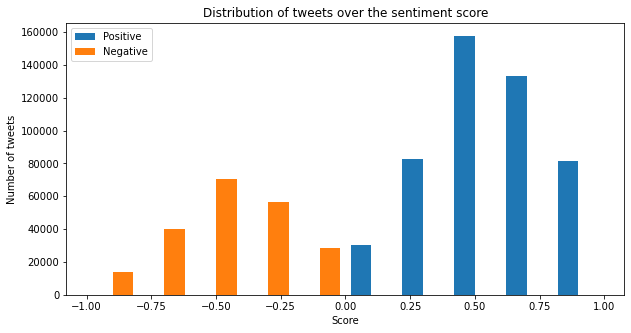

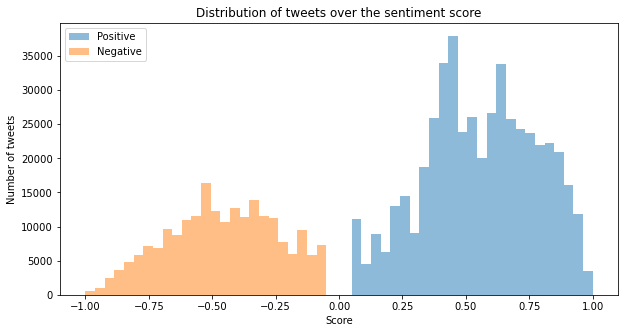

In [139]:
# Distribution of tweets over the sentiment score

plt.figure(figsize=(10,5))
plt.hist([pos_sents.sent_score, neg_sents.sent_score], bins=10, label=['Positive', 'Negative'])
plt.legend(loc = 'upper left')
plt.title('Distribution of tweets over the sentiment score')
plt.xlabel('Score')
plt.ylabel('Number of tweets')
plt.show()


plt.figure(figsize=(10,5))
plt.hist(pos_sents.sent_score, bins=25, alpha=0.5, label="Positive")
plt.hist(neg_sents.sent_score, bins=25, alpha=0.5, label="Negative")

plt.legend(loc = 'upper left')
plt.title('Distribution of tweets over the sentiment score')
plt.xlabel('Score')
plt.ylabel('Number of tweets')
plt.show()

# which nicer?

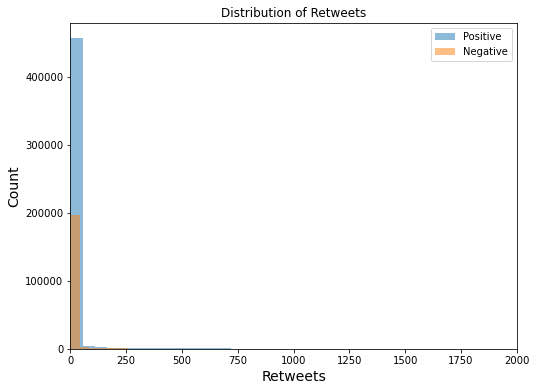

In [35]:
# Destribution of retweets in linear scale, considering the tweets with no retweets

plt.figure(figsize=(8,6))
plt.hist(pos_sents.retweet_count, bins=10000, alpha=0.5, label="Positive")
plt.hist(neg_sents.retweet_count, bins=10000, alpha=0.5, label="Negative")

plt.xlabel("Retweets", size=14)
plt.ylabel("Count", size=14)
plt.xlim(0, 2000)
plt.title("Distribution of Retweets")
plt.legend(loc='upper right')

The data seems to follow a power law with an heavy-tailed distribution, in the following graph we plot the data in a log-log scale. However, to do so, we need to remove the data with retweets recont equals to 0.

In [36]:
# only tweets which have been retweeted

pos_retweeted = pos_sents.loc[pos_sents['retweet_count'] > 0]
neg_retweeted = neg_sents.loc[neg_sents['retweet_count'] > 0]

In [ ]:
plt.figure(figsize=(20,8))
plt.suptitle('Distribution for retweet_count > 0')


# Distribution of tweets actually retweeted in linear scale
plt.subplot(1, 2, 1)
plt.hist(pos_retweeted.retweet_count, bins=10000, alpha=0.5, label="Positive")
plt.hist(neg_retweeted.retweet_count, bins=10000, alpha=0.5, label="Negative")

plt.xlabel("Retweets - Linear Scale", size=14)
plt.ylabel("Count - Linear Scale", size=14)
plt.xlim(0, 2000)
plt.title("Distribution of Retweets in linear scale")
plt.legend(loc='upper right')          
 
    
    
# Distribution of retweets in log log scale
plt.subplot(1, 2, 2)
plt.hist(pos_retweeted.retweet_count.apply(np.log), bins=100, alpha=0.5, label="Positive")
plt.hist(neg_retweeted.retweet_count.apply(np.log), bins=100, alpha=0.5, label="Negative")

plt.xlabel("Retweets - Log Scale", size=14)
plt.ylabel("Count - Log Scale", size=14)
plt.title("Distribution of Retweets in log-log scale")
plt.legend(loc='upper right')




The distribution of retweets seems even more skewed than a power law distribution. This means that we must not use statistics such as the mean value because they are highly unstable and misleadinhin this type of distribution.

In [37]:
pos_sents['retweet_count'].describe()

count    484802.000000
mean        265.132048
std        4166.262361
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      551788.000000
Name: retweet_count, dtype: float64

In [38]:
neg_sents['retweet_count'].describe()

count    209729.000000
mean        178.306386
std        2980.425162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      426173.000000
Name: retweet_count, dtype: float64

Also from this simple description of the data we can see that they are highly skewed. There are almost no data under the 75% quartile both for negative and positive tweets. 



When looking at simple statistics, we see that positive sentiment tweets have a much larger standard deviation, so there is more likely a significantly larger number of tweets with large retweet counts. 

In [39]:
# average of retweets in original df

print("The average number of retweets for positive tweets is {:.2f}".format(pos_sents.retweet_count.mean()))
print("The average number of retweets for negative tweets is {:.2f}".format(neg_sents.retweet_count.mean()))

The average number of retweets for positive tweets is 265.13
The average number of retweets for negative tweets is 178.31


In [40]:
# average of retweets for tweets that have been retweeted at least once

print("The average number of retweets for positive tweets is {:.2f}".format(pos_retweeted.retweet_count.mean()))
print("The average number of retweets for negative tweets is {:.2f}".format(neg_retweeted.retweet_count.mean()))

The average number of retweets for positive tweets is 1116.98
The average number of retweets for negative tweets is 731.85


In [41]:
pos_sents.sort_values(by=['retweet_count'], ascending = False)['retweet_count'].head(10)

453405     551788
971070     548016
1382810    473644
601483     337006
756569     322409
1097164    309553
1466955    298331
384720     297234
173075     284859
489620     274359
Name: retweet_count, dtype: int64

In [42]:
neg_sents.sort_values(by=['retweet_count'], ascending = False)['retweet_count'].head(10)

791467    426173
971292    290667
970966    237713
431728    226724
971090    201765
431141    196806
173016    181591
489521    178398
491761    169294
651023    167615
Name: retweet_count, dtype: int64

Also, looking at the top 10 highest retweeted tweets for positive tweets we find that positive tweets have higher max retween count. So, we need to try and filter the data to avoid effects of these very popular tweets.

**Given that our goal is to adress normal people so we could consider people with less that 1000 retweets. NOT SURE OF THAT**

In [43]:
# Creating a df with tweets retweeted at least once and less than 1000
pos_retweeted_filtered = pos_retweeted.loc[pos_retweeted['retweet_count'] < 1000]
neg_retweeted_filtered = neg_retweeted.loc[neg_retweeted['retweet_count'] < 1000]

print("The average number of retweets for positive tweets is {:.2f}".format(pos_retweeted_filtered.retweet_count.mean()))
print("The average number of retweets for negative tweets is {:.2f}".format(neg_retweeted_filtered.retweet_count.mean()))

The average number of retweets for positive tweets is 58.42
The average number of retweets for negative tweets is 63.06


In [44]:
stats.mannwhitneyu(pos_retweeted_filtered.retweet_count, neg_retweeted_filtered.retweet_count)

MannwhitneyuResult(statistic=2420987179.5, pvalue=0.0018021856744640191)

In [45]:
# If we consider in the mean also people who never got retweeted
pos_sents_filtered = pos_sents.loc[pos_sents['retweet_count'] < 1000]
neg_sents_filtered = neg_sents.loc[neg_sents['retweet_count'] < 1000]

print("The average number of retweets for positive tweets is {:.2f}".format(pos_sents_filtered.retweet_count.mean()))
print("The average number of retweets for negative tweets is {:.2f}".format(neg_sents_filtered.retweet_count.mean()))

The average number of retweets for positive tweets is 12.87
The average number of retweets for negative tweets is 14.36


In [46]:
# Describe what it does
stats.mannwhitneyu(pos_sents_filtered.retweet_count, neg_sents_filtered.retweet_count)

MannwhitneyuResult(statistic=48311587116.0, pvalue=3.263232738805855e-13)

In [70]:
print(f"There are {len(pos_sents_filtered.retweet_count)} positive tweets retweeted less than 1000 times and"
      f"among these only {len(pos_retweeted_filtered.retweet_count)} were retweeted at least once.", '\n')
print(f"There are {len(neg_sents_filtered.retweet_count)} negative tweets retweeted less than 1000 times and"
      f"among these only {len(neg_retweeted_filtered.retweet_count)} were retweeted at  least once.", '\n')

There are 474155 positive tweets retweeted less than 1000 times andamong these only 104428 were retweeted at least once. 

There are 205418 negative tweets retweeted less than 1000 times andamong these only 46787 were retweeted at  least once. 



In [61]:
pos_retweeted_filtered.retweet_count.value_counts()

1      44039
2      12544
3       6114
4       3770
5       2637
       ...  
856        2
948        2
898        1
816        1
995        1
Name: retweet_count, Length: 999, dtype: int64

In [62]:
pos_sents_filtered.retweet_count.value_counts()

0      369727
1       44039
2       12544
3        6114
4        3770
        ...  
860         2
751         2
816         1
995         1
898         1
Name: retweet_count, Length: 1000, dtype: int64

## Let's try some plots

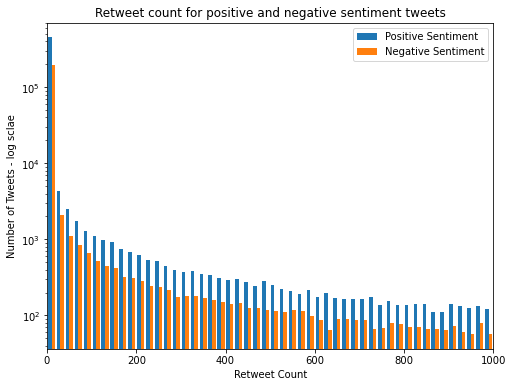

In [67]:
# with retweet < 1000
# I don't think we really care about these
plt.figure(figsize=(8,6))

plt.hist([pos_sents_filtered.retweet_count, neg_sents_filtered.retweet_count], bins=50, label=['Positive Sentiment', 'Negative Sentiment'])
plt.legend(loc = 'upper right')
plt.title('Retweet count for positive and negative sentiment tweets')
plt.xlabel('Retweet Count')
plt.ylabel('Number of Tweets - log sclae')
plt.yscale('log')
plt.xlim([0, 1000])
plt.show()

> Here I am trying to generate a percentage of retweeted filter. Using only tweets retweeted more than 1 and less than 1000.

In [114]:
tot_retw_pos = pos_retweeted_filtered.retweet_count.value_counts().sum()
tot_retw_neg = neg_retweeted_filtered.retweet_count.value_counts().sum()

In [115]:
pos_percent = pos_retweeted_filtered.retweet_count.value_counts()/tot_retw_pos
neg_percent = neg_retweeted_filtered.retweet_count.value_counts()/tot_retw_neg 

In [140]:
neg_percent # retweeted 1 time --> 42% of the total

1      0.418599
2      0.120739
3      0.056041
4      0.034176
5      0.025306
         ...   
984    0.000021
569    0.000021
729    0.000021
590    0.000021
837    0.000021
Name: retweet_count, Length: 982, dtype: float64

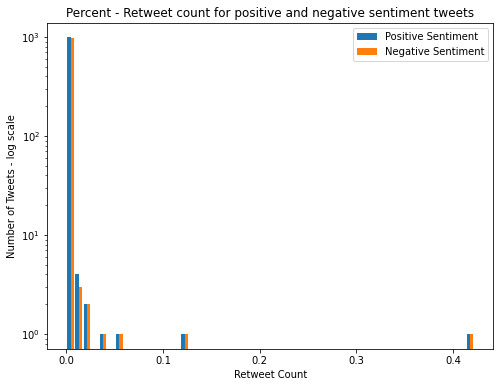

In [119]:
# trying with percentage
# with retweet > 0 ^ < 1000
plt.figure(figsize=(8,6))

plt.hist([pos_percent, neg_percent], bins=50, label=['Positive Sentiment', 'Negative Sentiment'])
plt.legend(loc = 'upper right')
plt.title('Percent - Retweet count for positive and negative sentiment tweets')
plt.xlabel('Retweet Count')
plt.ylabel('Number of Tweets - log scale')
plt.yscale('log')
plt.show()

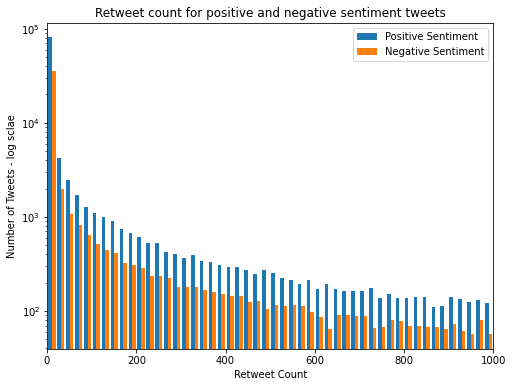

In [88]:
# with retweet > 0 ^ < 1000
plt.figure(figsize=(8,6))

plt.hist([pos_retweeted_filtered.retweet_count, neg_retweeted_filtered.retweet_count], bins=50, label=['Positive Sentiment', 'Negative Sentiment'])
plt.legend(loc = 'upper right')
plt.title('Retweet count for positive and negative sentiment tweets')
plt.xlabel('Retweet Count')
plt.ylabel('Number of Tweets - log scale')
plt.yscale('log')
plt.xlim([0, 1000])
plt.show()
# but yeah here we are calculating the total number of retweets, of course positive
# better because they are way more

**NOW THE PLOT IS DIFFERENT FROM WHAT CAMERON GOT WHYYYY**

It looks like the distribution of retweet count is very similar for both positive and negative tweets. However, there is a much larger set of positive tweets. Let's look at set of the same size

In [65]:
pos_same_size = pos_sents_filtered.sample(len(neg_sents_filtered))

print("Now we look at {} postive tweets and {} negative tweets".format(len(pos_same_size),len(neg_sents_filtered)))

Now we look at 205418 postive tweets and 205418 negative tweets


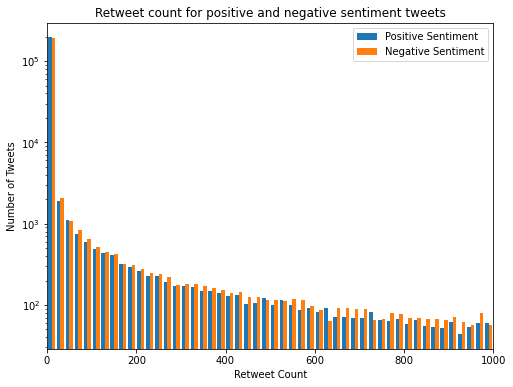

In [66]:
plt.figure(figsize=(8,6))

plt.hist([pos_same_size.retweet_count, neg_sents_filtered.retweet_count], bins=50, label=['Positive Sentiment', 'Negative Sentiment'])
plt.legend(loc = 'upper right')
plt.title('Retweet count for positive and negative sentiment tweets')
plt.xlabel('Retweet Count')
plt.ylabel('Number of Tweets')
plt.yscale('log')
plt.xlim([0, 1000])
plt.show()

From this distribution, we start to see that negative tweets tend to perform better in terms of retweet count. **NOW different from Cameron, why?**

## Step 8. Twitter Users Analysis

Here counting all tweets, no upper limit

In [120]:
perc_neg_ret = (len(neg_sents.loc[neg_sents['retweet_count']>0])/len(neg_sents))* 100
perc_pos_ret = (len(pos_sents.loc[pos_sents['retweet_count']>0])/len(pos_sents))* 100

print("{:.2f}% of positive tweets were retweeted and {:.2f}% of negative tweets were retweeted".format(perc_pos_ret,perc_neg_ret))

23.74% of positive tweets were retweeted and 24.36% of negative tweets were retweeted


In [121]:
en_tweets.groupby(["user_name"]).count()['clean_tweets']

user_name
  ♥ AaLiYaH ♥       82
 almer               2
 angieespino         2
 niallcumming        4
 العابرون            7
                  ... 
🕊                 2101
🗝                 1661
🦇 Trîstãn 🦇          1
🦊🐥🐰🐶🐱🐹              29
🧍‍♀️              2740
Name: clean_tweets, Length: 6167, dtype: int64

In [188]:
en_tweets.loc[en_tweets['user_name'] == 'almer'] #weird some people found above not here

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified,clean_tweets,no_sw_tweets,sent_score,sentiment


In [171]:
en_tweets.loc[en_tweets['user_name'] == '!KING!'] 


,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified,clean_tweets,no_sw_tweets,sent_score,sentiment
624941,NaN,Tue Jul 31 19:23:27 +0000 2012,NaN,NaN,http://instagr.am/p/Nwb_y3TXpR/,0,230383188730580992,NaN,NaN,NaN,...,!KING!,3King3Slim3,406,NaN,NaN,False,Us again....,Us again....,0.0000,neu
624949,NaN,Sun Jul 29 12:45:19 +0000 2012,NaN,NaN,http://instagr.am/p/NqkwGQTXjn/,0,229558220270743552,NaN,NaN,NaN,...,!KING!,3King3Slim3,406,NaN,NaN,False,Welcome 2 da fam,Welcome 2 da fam,0.4588,pos
624973,NaN,Wed Aug 15 05:11:56 +0000 2012,NaN,NaN,http://instagr.am/p/OVicsrTXiD/,0,235604716527169536,NaN,NaN,NaN,...,!KING!,3King3Slim3,406,NaN,NaN,False,Rest of Da Crew!,Rest of Da Crew!,0.0000,neu
624974,NaN,Mon Sep 10 14:40:29 +0000 2012,NaN,NaN,http://instagr.am/p/PZgIJmzXlc/,0,245169879920037888,NaN,NaN,NaN,...,!KING!,3King3Slim3,406,NaN,NaN,False,"In Math class, the first class of the day 4 me...","In Math class, first class of day 4 me. I'm 2 ...",0.0000,neu
624975,NaN,Mon Aug 20 12:32:44 +0000 2012,NaN,NaN,http://instagr.am/p/OjMr3-zXrj/,0,237527589030342656,NaN,NaN,NaN,...,!KING!,3King3Slim3,406,NaN,NaN,False,Dis time around I want all the Money!,Dis time around I want Money!,0.1511,pos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625363,NaN,Wed Mar 28 22:16:46 +0000 2012,NaN,NaN,NaN,0,185128323607834625,NaN,NaN,NaN,...,!KING!,3King3Slim3,406,NaN,NaN,False,So i finally took up a offer...... Ill be per...,So finally took offer...... Ill performing The...,0.0516,pos
625365,NaN,Tue Apr 03 00:30:18 +0000 2012,NaN,NaN,NaN,0,186973869326860288,AyoLilZo,1.869727e+17,45646000.0,...,!KING!,3King3Slim3,406,NaN,NaN,False,LMAO NOOOOOO MAN YOU TRIPPIN! LOL,LMAO NOOOOOO MAN YOU TRIPPIN! LOL,0.7901,pos
625366,NaN,Thu May 31 01:54:43 +0000 2012,NaN,NaN,NaN,0,208013607382953984,iLive_Dance,2.080103e+17,348235719.0,...,!KING!,3King3Slim3,406,NaN,NaN,False,that you are,,0.0000,neu
625368,NaN,Tue Mar 27 16:35:21 +0000 2012,cancer,NaN,NaN,0,184680013688340481,NaN,NaN,NaN,...,!KING!,3King3Slim3,406,NaN,NaN,False,You haven't experienced love until you have b...,You haven't experienced love cancer.. Very emo...,-0.7439,neg


In [174]:
print(en_tweets.loc[en_tweets['user_name'] == '!KING!'].retweet_count)
print(en_tweets.loc[en_tweets['user_name'] == '!KING!'].retweet_count.sum())

624941      0
624949      0
624973      0
624974      0
624975      0
         ... 
625363      1
625365      0
625366      0
625368    909
625369      1
Name: retweet_count, Length: 304, dtype: int64
25944


>In the case of this user, the majority of his tweets were not retweeted a lot but some of them very popular. 
We should somehow understand what is different in this tweet compared to the others

In [187]:
#Let's see some tweets from !KING!
en_tweets.loc[en_tweets.index == 625368]

# i dont manage to print it all why 

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified,clean_tweets,no_sw_tweets,sent_score,sentiment
625368,NaN,Tue Mar 27 16:35:21 +0000 2012,cancer,NaN,NaN,0,184680013688340481,NaN,NaN,NaN,...,!KING!,3King3Slim3,406,NaN,NaN,False,You haven't experienced love until you have b...,You haven't experienced love cancer.. Very emo...,-0.7439,neg


In [210]:
en_tweets.head(2)

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified,clean_tweets,no_sw_tweets,sent_score,sentiment
0,NaN,Sun Feb 14 23:29:33 +0000 2010,NaN,NaN,NaN,0,9116606357,NaN,NaN,NaN,...,Ina Gerdjikova,InaGerdjikova,6,NaN,http://kutiazamisli.blogspot.com/,False,Will try to live for a week offline... wish me...,Will try live week offline... wish luck! :D,0.8599,pos
3,NaN,Tue Aug 12 17:51:37 +0000 2014,NaN,NaN,http://twitcam.livestream.com/g7hpe,0,499251874256920577,NaN,NaN,NaN,...,Ana Paula Ribeiro,anadadal,7,NaN,NaN,False,Boa tarde.. ( live on,Boa tarde.. ( live,0.0000,neu


In [214]:
sent_follow = en_tweets.groupby(["user_name"]).apply(lambda x:  pd.Series({
        'total_tweets': x['clean_tweets'].count(),
        'pos_tweets': len(x.loc[x['sentiment'] == 'pos']),
        'neu_tweets': len(x.loc[x['sentiment'] == 'neu']),
        'neg_tweets': len(x.loc[x['sentiment'] == 'neg']),
        'num_followers': x['user_followers_count'].max(),
        'num_friends': x['user_friends_count'].max(),
        'num_retweet': x['retweet_count'].sum(),
        'num_retweet_pos': x.loc[x['sentiment'] == 'pos'].retweet_count.sum(),
        'num_retweet_neu': x.loc[x['sentiment'] == 'neu'].retweet_count.sum(),
        'num_retweet_neg': x.loc[x['sentiment'] == 'neg'].retweet_count.sum()
    }))

In [213]:
sent_follow.head(20)

,total_tweets,pos_tweets,neu_tweets,neg_tweets,num_followers,num_friends,num_retweet,num_retweet_pos,num_retweet_neu,num_retweet_neg
user_name,,,,,,,,,,
♥ AaLiYaH ♥,82,42,19,21,4,70,0,0,0,0
almer,2,1,1,0,3,26,9,9,0,0
angieespino,2,2,0,0,0,2,0,0,0,0
niallcumming,4,4,0,0,1,95,30,30,0,0
العابرون,7,6,1,0,55,136,13,13,0,0
! طــايــش بـــس عـا,1,1,0,0,8,217,0,0,0,0
!KING!,304,91,149,64,48,234,25944,18510,1386,6048
#EndSARS,181,96,43,42,134,158,19082,15922,63,3097
#GLAZERSOUT,331,170,116,45,43,358,152352,113559,27162,11631


In [215]:
print("Before filtering we have {} users to compare".format(len(sent_follow)))

Before filtering we have 6167 users to compare


In [237]:
# Filtering tweet users
sent_follow_filtered = sent_follow.loc[(sent_follow['total_tweets'] > 20) &
                                       (sent_follow['pos_tweets'] > 1) &
                                       (sent_follow['neg_tweets'] >1)&
                                       (sent_follow['num_retweet'] >0)]

In [238]:
print("After filtering we have {} users to compare".format(len(sent_follow_filtered)))

After filtering we have 1623 users to compare


In [239]:
# adding the percentages for number of positive and negative tweet
sent_follow_filtered['pos_perc'] = (sent_follow_filtered['pos_tweets']/sent_follow_filtered['total_tweets'])*100
sent_follow_filtered['neg_perc'] = (sent_follow_filtered['neg_tweets']/sent_follow_filtered['total_tweets'])*100

# adding the percentages for number of retweets of the positive and negative tweet
sent_follow_filtered['num_retweet_pos_perc'] = (sent_follow_filtered['num_retweet_pos']/sent_follow_filtered['num_retweet'])*100
sent_follow_filtered['num_retweet_neg_perc'] = (sent_follow_filtered['num_retweet_neg']/sent_follow_filtered['num_retweet'])*100




In [240]:
sent_follow_filtered.head(5)

,total_tweets,pos_tweets,neu_tweets,neg_tweets,num_followers,num_friends,num_retweet,num_retweet_pos,num_retweet_neu,num_retweet_neg,pos_perc,neg_perc,num_retweet_pos_perc,num_retweet_neg_perc
user_name,,,,,,,,,,,,,,
!KING!,304,91,149,64,48,234,25944,18510,1386,6048,29.934211,21.052632,71.345976,23.311748
#EndSARS,181,96,43,42,134,158,19082,15922,63,3097,53.038674,23.204420,83.439891,16.229955
#GLAZERSOUT,331,170,116,45,43,358,152352,113559,27162,11631,51.359517,13.595166,74.537256,7.634294
#Lucky#,177,78,54,45,15,51,1,0,0,1,44.067797,25.423729,0.000000,100.000000
#Neckup,2463,843,951,669,464,1292,78553,57518,11610,9425,34.226553,27.161998,73.221901,11.998269


In [243]:
# does the number of follower and sentiments somehow affect the retweetability?

df_followers = sent_follow_filtered.groupby('num_followers').agg({"neg_perc":"mean", "pos_perc":"mean", "num_retweet_neg_perc":"mean", "num_retweet_pos_perc":"mean"})
df_followers

,neg_perc,pos_perc,num_retweet_neg_perc,num_retweet_pos_perc
num_followers,,,,
0,20.975110,36.946687,19.812081,60.397064
1,21.470127,48.518011,24.708741,52.450616
2,18.096563,59.989072,9.086703,41.955794
3,20.989743,46.536634,28.765183,43.781068
4,14.789760,48.006605,24.119606,44.241546
...,...,...,...,...
22899,4.340963,64.167324,1.117647,43.000000
23503,23.747073,38.735363,27.372965,26.102615
24819,11.478145,48.048048,12.300950,50.021914


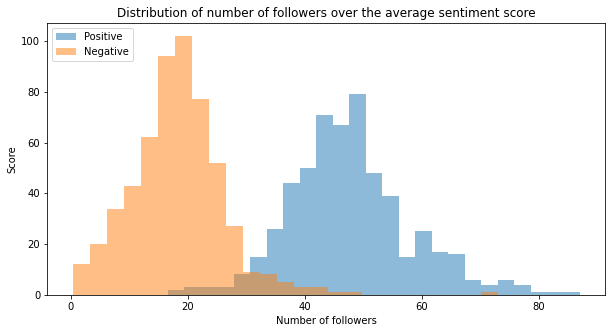

In [221]:
plt.figure(figsize=(10,5))
plt.hist(df_followers.pos_perc, bins=25, alpha=0.5, label="Positive")
plt.hist(df_followers.neg_perc, bins=25, alpha=0.5, label="Negative")

plt.legend(loc = 'upper left')
plt.title('Distribution of number of followers over the average sentiment score')
plt.xlabel('Number of followers')
plt.ylabel('Score')
plt.show()

I am not sure what this means

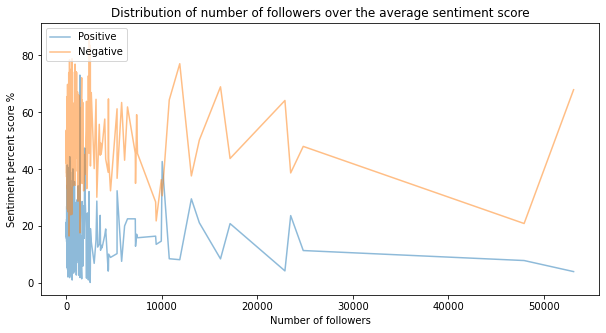

In [230]:
number_followers = df_followers.index

plt.figure(figsize=(10,5))
plt.plot(number_followers,df_followers.neg_perc, alpha=0.5, label="Positive")
plt.plot(number_followers,df_followers.pos_perc, alpha=0.5, label="Negative")

plt.legend(loc = 'upper left')
plt.title('Distribution of number of followers over the average sentiment score')
plt.xlabel('Number of followers')
plt.ylabel('Sentiment percent score %')
plt.show()

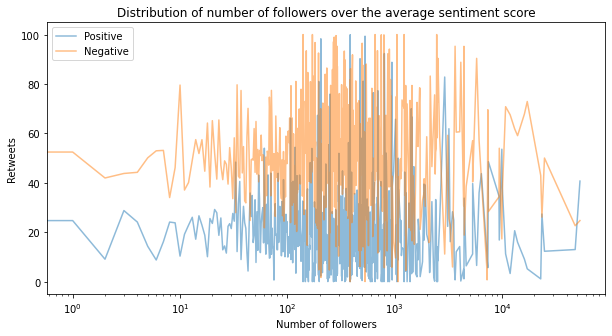

In [245]:
number_followers = df_followers.index

plt.figure(figsize=(10,5))
plt.plot(number_followers,df_followers.num_retweet_neg_perc, alpha=0.5, label="Positive")
plt.plot(number_followers,df_followers.num_retweet_pos_perc, alpha=0.5, label="Negative")

plt.legend(loc = 'upper left')
plt.title('Distribution of number of followers over the average sentiment score')
plt.xlabel('Number of followers')
plt.ylabel('Retweets')
#plt.yscale('log')
plt.xscale('log')

plt.show()

In [255]:
average_follower = 20
num_retweet_neg_perc_averaged = df_followers.num_retweet_neg_perc.rolling(average_follower, center=True).mean().dropna()
num_retweet_pos_perc_averaged = df_followers.num_retweet_pos_perc.rolling(average_follower, center=True).mean().dropna()

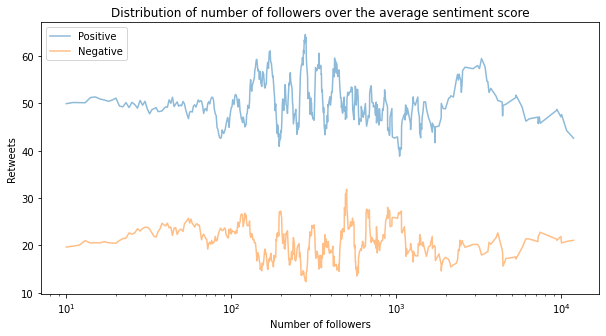

In [256]:
plt.figure(figsize=(10,5))
plt.plot(num_retweet_pos_perc_averaged.index, num_retweet_pos_perc_averaged, alpha=0.5, label="Positive")
plt.plot(num_retweet_neg_perc_averaged.index,num_retweet_neg_perc_averaged , alpha=0.5, label="Negative")

plt.legend(loc = 'upper left')
plt.title('Distribution of number of followers over the average sentiment score')
plt.xlabel('Number of followers')
plt.ylabel('Retweets')
#plt.yscale('log')
plt.xscale('log')

plt.show()

In [253]:
num_retweet_pos_perc_averaged

num_followers
5        47.919950
6        49.836265
7        48.298491
8        48.113580
9        48.635897
           ...    
13100    54.986862
13936    52.197494
16151    55.468617
17155    54.176353
22899    49.567495
Name: num_retweet_pos_perc, Length: 543, dtype: float64

(0.0, 5000.0)

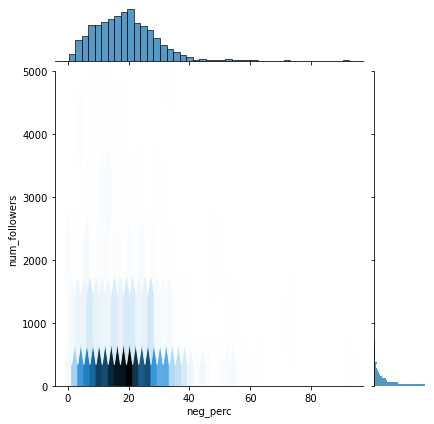

In [130]:

sns.jointplot(sent_follow_filtered['neg_perc'], sent_follow_filtered['num_followers'], kind="hex")
plt.ylim(0,5000)



(0.0, 2500.0)

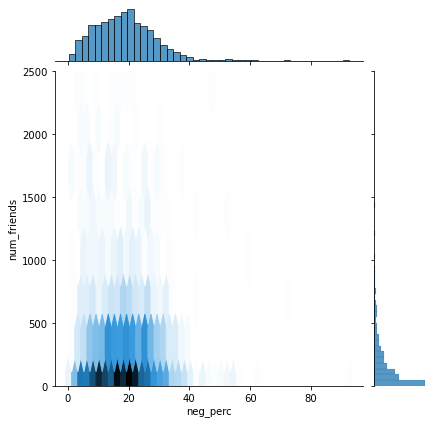

In [131]:
sns.jointplot(sent_follow_filtered['neg_perc'], sent_follow_filtered['num_friends'], kind="hex")
plt.ylim(0,2500)


(0.0, 5000.0)

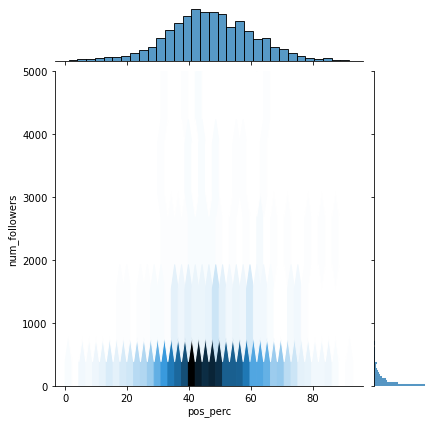

In [132]:
sns.jointplot(sent_follow_filtered['pos_perc'], sent_follow_filtered['num_followers'], kind="hex")
plt.ylim(0,5000)

(0.0, 2500.0)

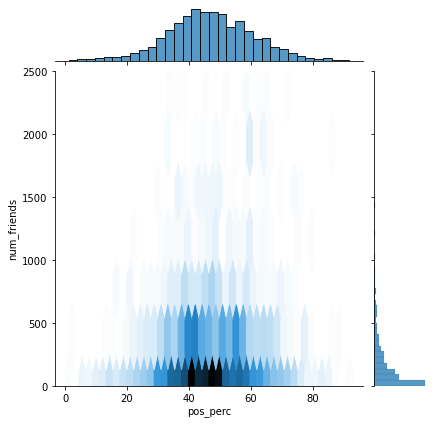

In [133]:
sns.jointplot(sent_follow_filtered['pos_perc'], sent_follow_filtered['num_friends'], kind="hex")
plt.ylim(0,2500)

## Step 6. Logistic Regression to see if retweetability linked to sentiments
___

## Step 7. Topic Analysis 
___

**Empath lexicon**

We are going to use [*Empath*](https://github.com/Ejhfast/empath-client), a tool for analyzing text across lexical categories. It will be used to extract tweets that can be related to a certain topic.

In [135]:
lexicon = Empath()

We show an example of usage for two different sentences

In [136]:
example_1 = "We love playing basketball"
example_2 = "We love playing the guitar"
for ex in [example_1, example_2]:
    print(f"Sentence:\t{ex}")
    print(f"Result:\t\t{lexicon.analyze(ex, categories = ['sports', 'music'])}")
    print(f"Normalized result:\t{lexicon.analyze(ex, categories = ['sports', 'music'], normalize = True)}\n")
    
print("Explanation: 'playing' and 'basketball' are in the sports keyword set,"
      " whereas 'guitar' falls into the music keywords set.")

Sentence:	We love playing basketball
Result:		{'sports': 2.0, 'music': 0.0}
Normalized result:	{'sports': 0.5, 'music': 0.0}

Sentence:	We love playing the guitar
Result:		{'sports': 1.0, 'music': 1.0}
Normalized result:	{'sports': 0.2, 'music': 0.2}

Explanation: 'playing' and 'basketball' are in the sports keyword set, whereas 'guitar' falls into the music keywords set.


**Lexical Categories**

In [ ]:
categories = list(lexicon.cats.keys())
categories.sort()
print(f"There are {len(categories)} predefined categories.\nSome of the categories are: {categories[:20] + ['...']}")
print(f"\nEach category contains a set of keywords:\nsports: {lexicon.cats['sports'][:20] + ['...']}")

We will select 8 of these categories:<br>*sports, politics, music, religion, health, cooking, fashion, and family*

In [ ]:
CATEGORIES = ["sports", "politics", "music", "religion", "health", "cooking", "fashion", "family"]

**Computing topic extraction**

Let's compute the category scores for each tweet, and then select the most probable category if any detected. Or load the already computed dataset (saving time).

In [ ]:
%%time
categorized_dataset = 'Data/categorized_tweets.csv'
load_df = False

if not os.path.isfile(categorized_dataset) or not load_df:
    
    def score_categories(x, cats=CATEGORIES):
        cat_scores = lexicon.analyze(x.text, categories = cats)
        return [int(x) for x in list(cat_scores.values())]

    df_cats = en_tweets.apply(score_categories, axis=1)
    df_cats = pd.DataFrame(df_cats.to_list(), index=df_cats.index, columns=CATEGORIES)
    en_tweets = en_tweets.join(df_cats)

    # Extracting the category with the maximum number of occurrences
    def max_category(x, cats=CATEGORIES):
        array = [x[cat] for cat in cats]
        if np.sum(array) == 0:
            res = np.nan
        elif array.count(max(array)) > 1:
            res = np.nan
        else:
            res = cats[np.argmax(array)]
        return res

    en_tweets['category'] = en_tweets[CATEGORIES].apply(max_category, axis=1)
    
    # Write dataset
    en_tweets.to_csv(categorized_dataset, index=False)
    
# Read already created dataset
elif os.path.isfile(categorized_dataset) and 'category' not in en_tweets.columns and load_df:
    en_tweets = pd.read_csv(categorized_dataset)

For each category, we have counted the number of keywords present in the text. Then, the category with more keywords is considered the actual category of the tweet.

In [ ]:
print(f"{en_tweets['category'].isna().value_counts()[False]} tweets were categorized;"
      f" {en_tweets['category'].isna().value_counts()[False]/len(en_tweets)*100:.2f}% of the total {len(en_tweets)} tweets.")

Categorized tweets keyword count:

In [ ]:
en_tweets[en_tweets.columns[-(len(CATEGORIES)+1):]][~en_tweets['category'].isna()].sample(n=4, random_state=0)

In [ ]:
counts_series = en_tweets['category'].value_counts()

plt.figure(figsize=(12,6))
ax = plt.bar(counts_series.index, counts_series.values)
plt.grid(axis='y')
plt.title('Amount of tweets per category')
plt.ylabel('Number of tweets')
plt.xlabel('Category')

# Showing labels
for rect, label in zip(ax.patches, counts_series.values):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()

## Group statistics

In [ ]:
group_stats =   (en_tweets[['category', 'text', 'retweet_count', 'favorite_count', 'retweetability']]
                 .groupby('category')
                 .agg({'text':'count', 'retweet_count':['mean', 'std'], 'retweetability':'mean', 'favorite_count':['mean', 'std']})
                 .sort_values(('retweet_count', 'mean'), ascending=False)
                )

In [ ]:
def highlight_max(data): #, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'font-weight: bold'
    #attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [ ]:
group_stats.style.apply(highlight_max, axis=0)# % 'bold')

## Showing some of the tweets

In [ ]:
def sample_tweets(cat, N=10, seed=None, min_rt=0):
    df_w = (en_tweets[(en_tweets['category']==cat) & (en_tweets['retweet_count'] > min_rt)]
            [['retweet_count', 'favorite_count', 'text', 'user_name']]
           )
    for rt, fav, tweet, user in df_w.sample(n=min(N, len(df_w)), random_state=None).values:
        print(f"RTs: {str(rt).ljust(4)}\tFavs: {str(fav).ljust(4)}\tUser: {user.ljust(15)} Tweet: {tweet}")

In [ ]:
sample_tweets('religion', min_rt=10)

> Pre-processing to remove repeated tweets. Cameron? Consistency with the other parts of the project

## Statistical Evaluation

In [ ]:
def bootstrap_stat_ci(array, statistic, repetitions=10000, alpha=0.05, resampling_size=None):
    if resampling_size is None:
        resampling_size = int(len(array))
    
    # For reproducibility
    np.random.seed(seed=0)
    
    bootstrap_distribution = []
    for i in range(repetitions):
        # resampled data
        bootstrap_sample = np.random.choice(array, size=resampling_size, replace=True)
        # computing the mean
        stat_sample = statistic(bootstrap_sample)
        # saving the statistic into the bootstrap distribution
        bootstrap_distribution.append(stat_sample)

    # Computing the bootstrap confidence interval
    mean = np.mean(bootstrap_distribution)
    left = np.percentile(bootstrap_distribution, alpha/2*100)
    right = np.percentile(bootstrap_distribution, (1-alpha/2)*100)
    
    return bootstrap_distribution, mean, (left, right)

def compute_statistic(statistic, categories, feature='retweet_count'):
    # Choosing statistic
    if statistic == 'mean':
        stat_func = lambda x: np.mean(x)
    elif statistic == 'mean_log':
        stat_func = lambda x: np.mean(np.log10(x))
    
    # Computing bootstrap ci per category
    x, l_err, r_err = [], [], []
    for cat in categories:
        values = en_tweets[en_tweets['category']==cat][feature][en_tweets[feature]>0].values
        _, mean, (l_ci, r_ci) = bootstrap_stat_ci(values, statistic=stat_func)
        x.append(mean)
        l_err.append(mean-l_ci)
        r_err.append(r_ci-mean)
    err = [l_err, r_err]
    return x, err

def plot_error_bar(x, err, categories, statistic_name=''):
    y = np.linspace(1, 2*len(x)-1, len(x))
    plt.figure(figsize=(10,5))
    plt.errorbar(x, y, xerr=err, fmt = 'o', color = 'k')
    plt.yticks(tuple([0] + list(y) + [y[-1]+1]), tuple([''] + categories + ['']))
    plt.title(statistic_name + ' per Category')
    plt.ylabel('Categories')
    plt.xlabel(statistic_name)
    plt.show()
    
def show(statistic, feature, categories):
    x, err = compute_statistic(statistic, categories, feature)
    plot_error_bar(x, err, categories, statistic_name=' '.join([x.replace('_', ' ').title() for x in [statistic, feature]]))

In [ ]:
show('mean', 'retweet_count', CATEGORIES)

In [ ]:
show('mean_log', 'retweet_count', CATEGORIES)

In [ ]:
show('mean', 'favorite_count', CATEGORIES)

In [ ]:
show('mean_log', 'favorite_count', CATEGORIES)

In [ ]:
is_neg = en_tweets['sentiment'] == 'neg'
is_pos = en_tweets['sentiment'] == 'pos'
cat_sent = en_tweets.loc[is_neg | is_pos]

In [ ]:
grouped_cat_sent = (cat_sent[['category', 'sentiment', 'text', 'retweet_count', 'favorite_count', 'retweetability']]
                 .groupby(["category", "sentiment"])
                 .agg({'text':'count', 'retweet_count':['mean', 'std'], 'retweetability':'mean', 'favorite_count':['mean', 'std']})
                 .sort_values(('retweet_count', 'mean'), ascending=False)
                )

In [ ]:
grouped_cat_sent.style.apply(highlight_max, axis=0)# % 'bold')

---------------
# EXTRA CODE

## Plotting retweet and favorite distributions

In [ ]:
ax = sns.boxplot(x="category", y="retweet_count", data=df)

In [ ]:
categories = CATEGORIES[:3]

plt.figure(figsize=(12,6))
for cat in categories:
    plt.hist(df[df['category']==cat]['retweet_count'][df['retweet_count']>0].values, bins=50, alpha=0.3, density=True)
plt.legend(categories)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Retweets')
plt.ylabel('Frequency')
plt.show()

**Fitting a power law**

Its pdf is \\( f(x,a) = ax^{a-1} \\)

In [ ]:
plot_error_bar(x, err, statistic_name='Mean retweets')

In [ ]:
x = [2, 4, 3]
y = np.linspace(1, 2*len(x)-1, len(x))
errors = [0.5, 0.25, 0.75]

plt.figure()
plt.errorbar(x, y, xerr=errors, fmt = 'o', color = 'k')
#plt.yticks((0, 1, 3, 5, 6), ('', 'x3', 'x2', 'x1',''))
plt.show()

In [ ]:
plt.boxplot(mean, conf_intervals=[[l_ci, r_ci])

In [ ]:
plt.boxplot(rt_sports, bootstrap=10000)

In [ ]:
# Plotting the bootstrap distribution

plt.figure(figsize=(10,5))
plt.hist(bootstrap_distribution, bins=45)
plt.title('Bootstrap distribution')
plt.ylabel('Counts')
plt.xlabel('Probability for a prediction being off by more than 2 points')
plt.axvline(x=left, color='red')
plt.legend(['Confidence Interval', 'Distribution'])
plt.axvline(x=right, color='red')
plt.show()

In [ ]:
scipy.stats.powerlaw.fit(rt_sports)

In [ ]:
categories = CATEGORIES

plt.figure(figsize=(12,6))
for cat in categories:
    plt.hist(df[df['category']==cat]['favorite_count'].values, bins=50, alpha=0.3, density=True)
plt.legend(categories)
plt.yscale('log')
plt.xlabel('Favorites')
plt.ylabel('Frequency')
plt.show()